In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dipole

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield, lf3d, j3d
from mhsflex.vis import plot
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt

from mhsflex.poloidal import (
    phi,
    phi_low,
    phi_hypgeo,
    dphidz_hypgeo,
    dphidz,
    dphidz_low,
)

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c1 = (0.439, 0.788, 1.000)
c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nresol_x = 20
nresol_y = 20
nresol_z = 20
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = 20

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [4]:
a = 0.44
alpha = 0.05
b = 1.0
z0 = 2.0

In [5]:
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * data2d.px
length_scale_y = 2.0 * nresol_y * data2d.py

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha**2) / (2 * k2_arr)

In [6]:
deltaz = 0.2
p_arr02 = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a - a * b) - alpha**2)
)
q_arr02 = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a + a * b) - alpha**2)
)

In [7]:
deltaz = 1.0
p_arr1 = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a - a * b) - alpha**2)
)
q_arr1 = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a + a * b) - alpha**2)
)

In [8]:
deltaz = 2.0
p_arr2 = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a - a * b) - alpha**2)
)
q_arr2 = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a + a * b) - alpha**2)
)

In [9]:
phi_asymp02 = np.zeros((nf_max, nf_max, nresol_z))
phi_asymp1 = np.zeros((nf_max, nf_max, nresol_z))
phi_asymp2 = np.zeros((nf_max, nf_max, nresol_z))

phi_hyp02 = np.zeros((nf_max, nf_max, nresol_z))
phi_hyp1 = np.zeros((nf_max, nf_max, nresol_z))
phi_hyp2 = np.zeros((nf_max, nf_max, nresol_z))

In [10]:
for iz, z in enumerate(z_arr):
    phi_asymp02[:, :, iz] = phi(z, p_arr02, q_arr02, z0, 0.2)
    phi_asymp1[:, :, iz] = phi(z, p_arr1, q_arr1, z0, 1.0)
    phi_asymp2[:, :, iz] = phi(z, p_arr2, q_arr2, z0, 2.0)

    phi_hyp02[:, :, iz] = phi_hypgeo(z, p_arr02, q_arr02, z0, 0.2)
    phi_hyp1[:, :, iz] = phi_hypgeo(z, p_arr1, q_arr1, z0, 1.0)
    phi_hyp2[:, :, iz] = phi_hypgeo(z, p_arr2, q_arr2, z0, 2.0)

In [11]:
ix_max = np.unravel_index(data2d.bz.argmax(), data2d.bz.shape)[1]
iy_max = np.unravel_index(data2d.bz.argmax(), data2d.bz.shape)[0]

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_6786/2515390563.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


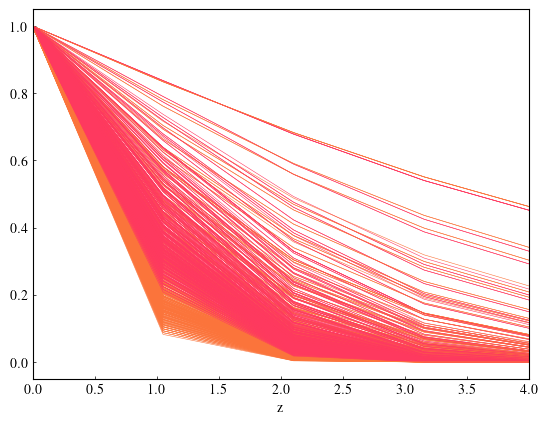

In [12]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        # plt.plot(
        #     z_arr,
        #     phi_asymp02[iy, ix, :],
        #     linewidth=0.4,
        #     color=c2,
        #     # label="N+N (2024)",
        # )
        # plt.plot(
        #     z_arr,
        #     phi_asymp1[iy, ix, :],
        #     linewidth=0.4,
        #     color=c1,
        #     # label="N+N (2024)",
        # )
        plt.plot(
            z_arr,
            phi_asymp2[iy, ix, :],
            linewidth=0.4,
            color=c4,
            # label="N+N (2024)",
        )

        # plt.plot(
        #     z_arr,
        #     phi_hyp02[iy, ix, :],
        #     linewidth=0.4,
        #     color=c5,
        #     # label="N+N (2024)",
        # )
        # plt.plot(
        #     z_arr,
        #     phi_hyp1[iy, ix, :],
        #     linewidth=0.4,
        #     color=c8,
        #     # label="N+N (2024)",
        # )
        plt.plot(
            z_arr,
            phi_hyp2[iy, ix, :],
            linewidth=0.4,
            color=c10,
            # label="N+N (2024)",
        )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
# plt.ylabel(r"$\bar{\Phi}$")
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_6786/3836231278.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


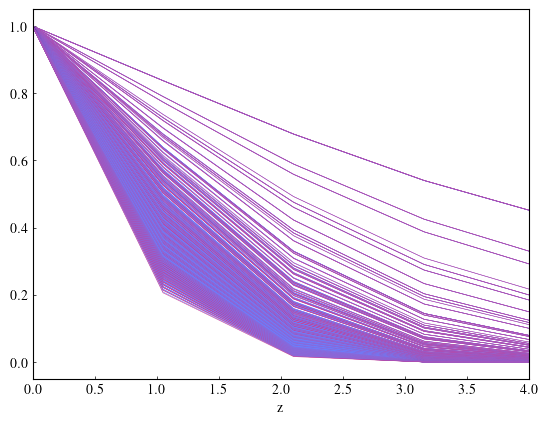

In [13]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        plt.plot(
            z_arr,
            phi_asymp02[iy, ix, :],
            linewidth=0.4,
            color=c2,
            # label="N+N (2024)",
        )
        # plt.plot(
        #     z_arr,
        #     phi_asymp1[iy, ix, :],
        #     linewidth=0.4,
        #     color=c1,
        #     # label="N+N (2024)",
        # )
        # plt.plot(
        #     z_arr,
        #     phi_asymp2[iy, ix, :],
        #     linewidth=0.4,
        #     color=c4,
        #     # label="N+N (2024)",
        # )

        plt.plot(
            z_arr,
            phi_hyp02[iy, ix, :],
            linewidth=0.4,
            color=c5,
            # label="N+N (2024)",
        )
        # plt.plot(
        #     z_arr,
        #     phi_hyp1[iy, ix, :],
        #     linewidth=0.4,
        #     color=c8,
        #     # label="N+N (2024)",
        # )
        # plt.plot(
        #     z_arr,
        #     phi_hyp2[iy, ix, :],
        #     linewidth=0.4,
        #     color=c10,
        #     # label="N+N (2024)",
        # )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
# plt.ylabel(r"$\bar{\Phi}$")
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_6786/428819388.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


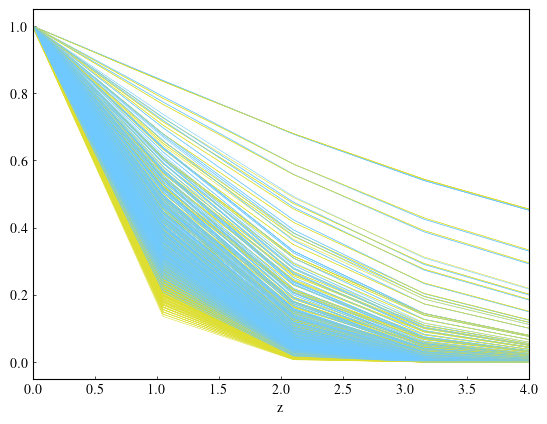

In [14]:
for ix in range(nresol_x):
    for iy in range(nresol_y):
        # plt.plot(
        #     z_arr,
        #     phi_asymp02[iy, ix, :],
        #     linewidth=0.4,
        #     color=c2,
        #     # label="N+N (2024)",
        # )
        plt.plot(
            z_arr,
            phi_asymp1[iy, ix, :],
            linewidth=0.4,
            color=c1,
            # label="N+N (2024)",
        )
        # plt.plot(
        #     z_arr,
        #     phi_asymp2[iy, ix, :],
        #     linewidth=0.4,
        #     color=c4,
        #     # label="N+N (2024)",
        # )

        # plt.plot(
        #     z_arr,
        #     phi_hyp02[iy, ix, :],
        #     linewidth=0.4,
        #     color=c5,
        #     # label="N+N (2024)",
        # )
        plt.plot(
            z_arr,
            phi_hyp1[iy, ix, :],
            linewidth=0.4,
            color=c8,
            # label="N+N (2024)",
        )
        # plt.plot(
        #     z_arr,
        #     phi_hyp2[iy, ix, :],
        #     linewidth=0.4,
        #     color=c10,
        #     # label="N+N (2024)",
        # )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
# plt.ylabel(r"$\bar{\Phi}$")
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [15]:
data3d_02 = calculate_magfield(data2d, a, b, alpha, z0, 0.2)
data3dNW_02 = calculate_magfield(data2d, a, b, alpha, z0, 0.2, asymptotic=False)

In [16]:
data3d_10 = calculate_magfield(data2d, a, b, alpha, z0, 1.0)
data3dNW_10 = calculate_magfield(data2d, a, b, alpha, z0, 1.0, asymptotic=False)
data3d_20 = calculate_magfield(data2d, a, b, alpha, z0, 2.0)
data3dNW_20 = calculate_magfield(data2d, a, b, alpha, z0, 2.0, asymptotic=False)

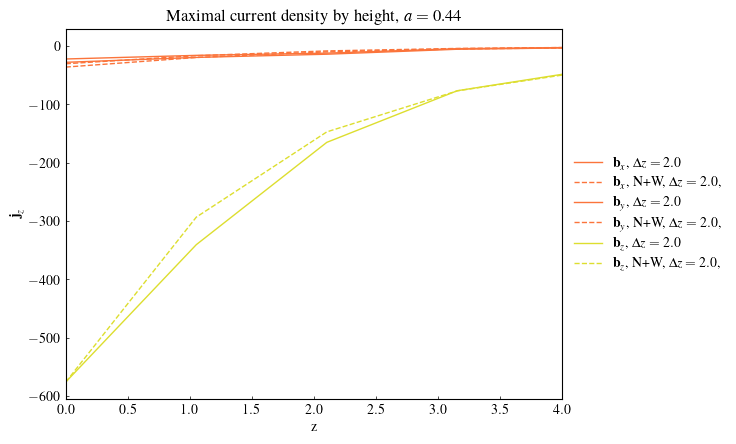

In [17]:
fig, ax1 = plt.subplots()

# ax1.plot(
#     data3d_02.z,
#     data3d_02.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c1,
#     label=r"$\textbf{b}_x$, $\Delta z = 0.2$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_02.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="--",
#     color=c1,
#     label=r"$\textbf{b}_x$, N+W, $\Delta z = 0.2$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_02.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c1,
#     label=r"$\textbf{b}_y$, $\Delta z = 0.2$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_02.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="--",
#     color=c1,
#     label=r"$\textbf{b}_y$, N+W, $\Delta z = 0.2$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_02.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c2,
#     label=r"$\textbf{b}_z$, $\Delta z = 0.2$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_02.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="--",
#     color=c2,
#     label=r"$\textbf{b}_z$, N+W, $\Delta z = 0.2$, ",
# )

# ax1.plot(
#     data3d_02.z,
#     data3d_10.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c4,
#     label=r"$\textbf{b}_z$, $\Delta z = 1.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_10.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="--",
#     color=c4,
#     label=r"$\textbf{b}_z$, N+W, $\Delta z = 1.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_10.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c5,
#     label=r"$\textbf{b}_x$, $\Delta z = 1.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_10.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="--",
#     color=c5,
#     label=r"$\textbf{b}_x$, N+W, $\Delta z = 1.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_10.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c5,
#     label=r"$\textbf{b}_y$, $\Delta z = 1.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_10.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="--",
#     color=c5,
#     label=r"$ \textbf{b}_y$, N+W, $\Delta z = 1.0$, ",
# )

ax1.plot(
    data3d_02.z,
    data3d_20.field[iy_max, ix_max, :, 1],
    linewidth=1.0,
    linestyle="solid",
    color=c10,
    label=r"$\textbf{b}_x$, $\Delta z = 2.0$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_20.field[iy_max, ix_max, :, 1],
    linewidth=1.0,
    linestyle="--",
    color=c10,
    label=r"$\textbf{b}_x$, N+W, $\Delta z = 2.0$, ",
)
ax1.plot(
    data3d_02.z,
    data3d_20.field[iy_max, ix_max, :, 0],
    linewidth=1.0,
    linestyle="solid",
    color=c10,
    label=r"$\textbf{b}_y$, $\Delta z = 2.0$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_20.field[iy_max, ix_max, :, 0],
    linewidth=1.0,
    linestyle="--",
    color=c10,
    label=r"$\textbf{b}_y$, N+W, $\Delta z = 2.0$, ",
)
ax1.plot(
    data3d_02.z,
    data3d_20.field[iy_max, ix_max, :, 2],
    linewidth=1.0,
    linestyle="solid",
    color=c8,
    label=r"$\textbf{b}_z$, $\Delta z = 2.0$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_20.field[iy_max, ix_max, :, 2],
    linewidth=1.0,
    linestyle="--",
    color=c8,
    label=r"$\textbf{b}_z$, N+W, $\Delta z = 2.0$, ",
)


ax1.set_xlabel("z")
plt.xlim([0, 2 * z0])
ax1.tick_params(direction="in", length=2, width=0.5)
#
plt.title(
    r"Maximal current density by height, $a =$ " + str(a)
)
lines1, labels1 = ax1.get_legend_handles_labels()
#
lines = lines1 #
labels = labels1 #
ax1.set_ylabel(r"$\textbf{j}_z$")
#ax2.set_ylabel(r"$(\textbf{j} \times \textbf{B})_x, (\textbf{j} \times \textbf{B})_y$")
plt.legend(lines, labels, frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
# plotname = "/Users/lilli/Desktop/Thesis/Performance/J/" + str(a) + "/maxJ_by_z_all.png"
# plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

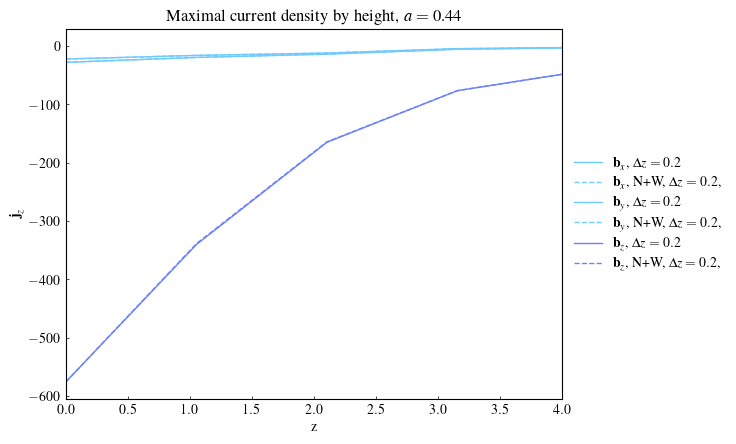

In [18]:
fig, ax1 = plt.subplots()

ax1.plot(
    data3d_02.z,
    data3d_02.field[iy_max, ix_max, :, 1],
    linewidth=1.0,
    linestyle="solid",
    color=c1,
    label=r"$\textbf{b}_x$, $\Delta z = 0.2$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_02.field[iy_max, ix_max, :, 1],
    linewidth=1.0,
    linestyle="--",
    color=c1,
    label=r"$\textbf{b}_x$, N+W, $\Delta z = 0.2$, ",
)
ax1.plot(
    data3d_02.z,
    data3d_02.field[iy_max, ix_max, :, 0],
    linewidth=1.0,
    linestyle="solid",
    color=c1,
    label=r"$\textbf{b}_y$, $\Delta z = 0.2$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_02.field[iy_max, ix_max, :, 0],
    linewidth=1.0,
    linestyle="--",
    color=c1,
    label=r"$\textbf{b}_y$, N+W, $\Delta z = 0.2$, ",
)
ax1.plot(
    data3d_02.z,
    data3d_02.field[iy_max, ix_max, :, 2],
    linewidth=1.0,
    linestyle="solid",
    color=c2,
    label=r"$\textbf{b}_z$, $\Delta z = 0.2$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_02.field[iy_max, ix_max, :, 2],
    linewidth=1.0,
    linestyle="--",
    color=c2,
    label=r"$\textbf{b}_z$, N+W, $\Delta z = 0.2$, ",
)

# ax1.plot(
#     data3d_02.z,
#     data3d_10.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c4,
#     label=r"$\textbf{b}_z$, $\Delta z = 1.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_10.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="--",
#     color=c4,
#     label=r"$\textbf{b}_z$, N+W, $\Delta z = 1.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_10.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c5,
#     label=r"$\textbf{b}_x$, $\Delta z = 1.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_10.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="--",
#     color=c5,
#     label=r"$\textbf{b}_x$, N+W, $\Delta z = 1.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_10.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c5,
#     label=r"$\textbf{b}_y$, $\Delta z = 1.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_10.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="--",
#     color=c5,
#     label=r"$ \textbf{b}_y$, N+W, $\Delta z = 1.0$, ",
# )

# ax1.plot(
#     data3d_02.z,
#     data3d_20.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c10,
#     label=r"$\textbf{b}_x$, $\Delta z = 2.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_20.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="--",
#     color=c10,
#     label=r"$\textbf{b}_x$, N+W, $\Delta z = 2.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_20.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c10,
#     label=r"$\textbf{b}_y$, $\Delta z = 2.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_20.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="--",
#     color=c10,
#     label=r"$\textbf{b}_y$, N+W, $\Delta z = 2.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_20.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c8,
#     label=r"$\textbf{b}_z$, $\Delta z = 2.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_20.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="--",
#     color=c8,
#     label=r"$\textbf{b}_z$, N+W, $\Delta z = 2.0$, ",
# )


ax1.set_xlabel("z")
plt.xlim([0, 2 * z0])
ax1.tick_params(direction="in", length=2, width=0.5)
#
plt.title(
    r"Maximal current density by height, $a =$ " + str(a)
)
lines1, labels1 = ax1.get_legend_handles_labels()
#
lines = lines1 #
labels = labels1 #
ax1.set_ylabel(r"$\textbf{j}_z$")
#ax2.set_ylabel(r"$(\textbf{j} \times \textbf{B})_x, (\textbf{j} \times \textbf{B})_y$")
plt.legend(lines, labels, frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
# plotname = "/Users/lilli/Desktop/Thesis/Performance/J/" + str(a) + "/maxJ_by_z_all.png"
# plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

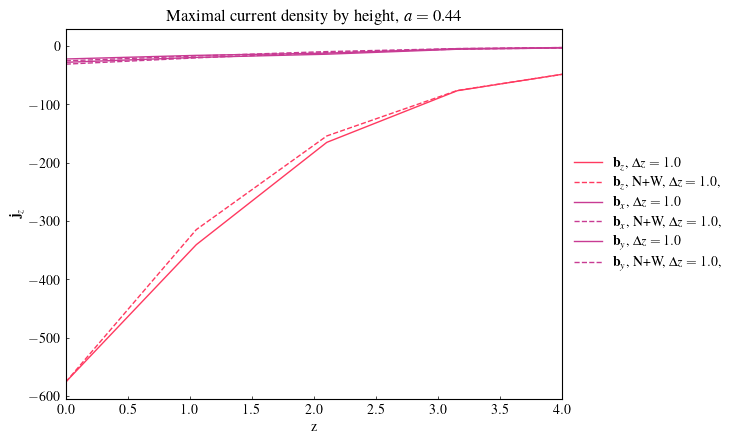

In [19]:
fig, ax1 = plt.subplots()

# ax1.plot(
#     data3d_02.z,
#     data3d_02.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c1,
#     label=r"$\textbf{b}_x$, $\Delta z = 0.2$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_02.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="--",
#     color=c1,
#     label=r"$\textbf{b}_x$, N+W, $\Delta z = 0.2$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_02.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c1,
#     label=r"$\textbf{b}_y$, $\Delta z = 0.2$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_02.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="--",
#     color=c1,
#     label=r"$\textbf{b}_y$, N+W, $\Delta z = 0.2$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_02.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c2,
#     label=r"$\textbf{b}_z$, $\Delta z = 0.2$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_02.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="--",
#     color=c2,
#     label=r"$\textbf{b}_z$, N+W, $\Delta z = 0.2$, ",
# )

ax1.plot(
    data3d_02.z,
    data3d_10.field[iy_max, ix_max, :, 2],
    linewidth=1.0,
    linestyle="solid",
    color=c4,
    label=r"$\textbf{b}_z$, $\Delta z = 1.0$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_10.field[iy_max, ix_max, :, 2],
    linewidth=1.0,
    linestyle="--",
    color=c4,
    label=r"$\textbf{b}_z$, N+W, $\Delta z = 1.0$, ",
)
ax1.plot(
    data3d_02.z,
    data3d_10.field[iy_max, ix_max, :, 1],
    linewidth=1.0,
    linestyle="solid",
    color=c5,
    label=r"$\textbf{b}_x$, $\Delta z = 1.0$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_10.field[iy_max, ix_max, :, 1],
    linewidth=1.0,
    linestyle="--",
    color=c5,
    label=r"$\textbf{b}_x$, N+W, $\Delta z = 1.0$, ",
)
ax1.plot(
    data3d_02.z,
    data3d_10.field[iy_max, ix_max, :, 0],
    linewidth=1.0,
    linestyle="solid",
    color=c5,
    label=r"$\textbf{b}_y$, $\Delta z = 1.0$",
)
ax1.plot(
    data3d_02.z,
    data3dNW_10.field[iy_max, ix_max, :, 0],
    linewidth=1.0,
    linestyle="--",
    color=c5,
    label=r"$ \textbf{b}_y$, N+W, $\Delta z = 1.0$, ",
)

# ax1.plot(
#     data3d_02.z,
#     data3d_20.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c10,
#     label=r"$\textbf{b}_x$, $\Delta z = 2.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_20.field[iy_max, ix_max, :, 1],
#     linewidth=1.0,
#     linestyle="--",
#     color=c10,
#     label=r"$\textbf{b}_x$, N+W, $\Delta z = 2.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_20.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c10,
#     label=r"$\textbf{b}_y$, $\Delta z = 2.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_20.field[iy_max, ix_max, :, 0],
#     linewidth=1.0,
#     linestyle="--",
#     color=c10,
#     label=r"$\textbf{b}_y$, N+W, $\Delta z = 2.0$, ",
# )
# ax1.plot(
#     data3d_02.z,
#     data3d_20.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="solid",
#     color=c8,
#     label=r"$\textbf{b}_z$, $\Delta z = 2.0$",
# )
# ax1.plot(
#     data3d_02.z,
#     data3dNW_20.field[iy_max, ix_max, :, 2],
#     linewidth=1.0,
#     linestyle="--",
#     color=c8,
#     label=r"$\textbf{b}_z$, N+W, $\Delta z = 2.0$, ",
# )


ax1.set_xlabel("z")
plt.xlim([0, 2 * z0])
ax1.tick_params(direction="in", length=2, width=0.5)
#
plt.title(
    r"Maximal current density by height, $a =$ " + str(a)
)
lines1, labels1 = ax1.get_legend_handles_labels()
#
lines = lines1 #
labels = labels1 #
ax1.set_ylabel(r"$\textbf{j}_z$")
#ax2.set_ylabel(r"$(\textbf{j} \times \textbf{B})_x, (\textbf{j} \times \textbf{B})_y$")
plt.legend(lines, labels, frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
# plotname = "/Users/lilli/Desktop/Thesis/Performance/J/" + str(a) + "/maxJ_by_z_all.png"
# plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()